# FCNs
train model & save result

## Data
* data : v1-v4
* n_class : 2
* duration : 3
* sampling_rate : 1000
* n_samples : 10000 (5000:5000)
* heart_rate : random between 60 to 100
* noise : bw, mt, ac



In [1]:
import numpy as np
import pickle
import time
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
import tensorflow as tf

import matplotlib.pyplot as plt


## Load Data


In [2]:
import os

os.environ["KAGGLE_USERNAME"] = "nnttch"
os.environ["KAGGLE_KEY"] = " "

In [3]:
!pip -q uninstall kaggle
!pip -q install kaggle

Proceed (y/n)? y
     |████████████████████████████████| 61kB 5.2MB/s 


In [4]:
!kaggle datasets download nnttch/ecg-simulation

!unzip *.zip
!ls

100% 3.41G/3.41G [01:03<00:00, 34.0MB/s]
100% 3.41G/3.41G [01:03<00:00, 58.1MB/s]
Archive:  ecg-simulation.zip
  inflating: data/ecg5000.pkl        
  inflating: data/ecg_bw5000.pkl     
  inflating: data/ecg_gn5000.pkl     
  inflating: data/ecg_ma5000.pkl     
  inflating: data/ecgste5000.pkl     
  inflating: data/ecgste_bw5000.pkl  
  inflating: data/ecgste_gn5000.pkl  
  inflating: data/ecgste_ma5000.pkl  
data  ecg-simulation.zip  sample_data


In [5]:
def load_data(file_name):
  filehandler = open(file_name, 'rb')
  data = pickle.load(filehandler)
  filehandler.close()
  return data


In [6]:
# none
ecg5000 = load_data('data/ecg5000.pkl')
ecg5000['label'] = 0
ecgste5000 = load_data('data/ecgste5000.pkl')
ecgste5000['label'] = 1
df = pd.concat([ecg5000, ecgste5000], axis=0)

# bw
ecg_bw5000 = load_data('data/ecg_bw5000.pkl')
ecg_bw5000['label'] = 0
ecgste_bw5000 = load_data('data/ecgste_bw5000.pkl')
ecgste_bw5000['label'] = 1
df_bw = pd.concat([ecg_bw5000, ecgste_bw5000], axis=0)

# ma
ecg_ma5000 = load_data('data/ecg_ma5000.pkl')
ecg_ma5000['label'] = 0
ecgste_ma5000 = load_data('data/ecgste_ma5000.pkl')
ecgste_ma5000['label'] = 1
df_ma = pd.concat([ecg_ma5000, ecgste_ma5000], axis=0)

# gn
ecg_gn5000 = load_data('data/ecg_gn5000.pkl')
ecg_gn5000['label'] = 0
ecgste_gn5000 = load_data('data/ecgste_gn5000.pkl')
ecgste_gn5000['label'] = 1
df_gn = pd.concat([ecg_gn5000, ecgste_gn5000], axis=0)


In [7]:
print(df.shape)
print(df_bw.shape)
print(df_ma.shape)
print(df_gn.shape)

(10000, 6)
(10000, 6)
(10000, 6)
(10000, 6)


## Preprocessing

In [8]:
# data preprocessing
def get_input(df):
  '''
    preprocessing data from DataFrame to feed into Neural Network
    the input dimensions should be (m, tx, nx)
    m: number of samples
    tx: number of time points
    nx: number of features
  '''

  data = []
  for i in range(df.shape[0]):
    smp_data = np.vstack(df[['v1', 'v2', 'v3', 'v4']].values[i]).T
    data.append(smp_data)

  X = np.array(data)
  y = df['label']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)
  
  print("Train set: {}".format(X_train.shape))
  print("Test set : {}".format(X_test.shape))

  return X_train, X_test, y_train, y_test


## Train & Save Models
save model, training history, duration
* fcn_df
* fcn_dfbw
* fcn_dfma
* fcn_dfac

In [10]:
# FCNs
def build_model(input_shape, nb_classes):

  input_layer = keras.layers.Input(input_shape)

  conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
  conv1 = keras.layers.BatchNormalization()(conv1)
  conv1 = keras.layers.Activation(activation='relu')(conv1)

  conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
  conv2 = keras.layers.BatchNormalization()(conv2)
  conv2 = keras.layers.Activation(activation='relu')(conv2)

  conv3 = keras.layers.Conv1D(filters=128, kernel_size=3, padding='same')(conv2)
  conv3 = keras.layers.BatchNormalization()(conv3)
  conv3 = keras.layers.Activation(activation='relu')(conv3)

  gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

  output_layer = keras.layers.Dense(nb_classes, activation='sigmoid')(gap_layer)

  model = keras.models.Model(inputs=input_layer, outputs=output_layer)

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), 
                metrics=['accuracy'])
  
  return model


### fcn_df

In [11]:
# get_input
X_train, X_test, y_train, y_test = get_input(df)

# model
input_shape = X_train.shape[1:]
nb_classes = 1

batch_size = 16
nb_epochs = 10 #5000

fcn_df = build_model(input_shape, nb_classes)

start_time = time.time()
history = fcn_df.fit(X_train, y_train, validation_split=0.30, 
                     epochs=nb_epochs, batch_size=batch_size, verbose=0)
duration = time.time() - start_time

fcn_df.summary()

Train set: (8000, 3000, 4)
Test set : (2000, 3000, 4)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3000, 4)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3000, 128)         4224      
_________________________________________________________________
batch_normalization (BatchNo (None, 3000, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 3000, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3000, 256)         164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3000, 256)         1024      
_________________________________________________________________
activat

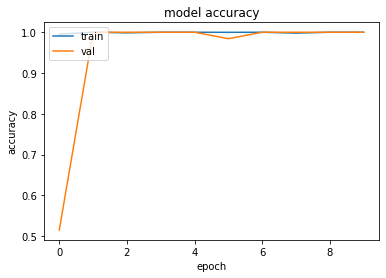

In [12]:
# history of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

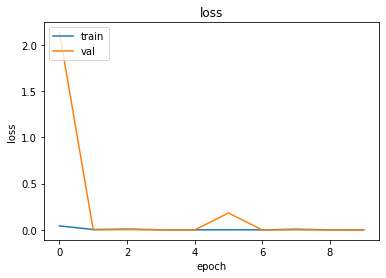

In [13]:
# history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
len(fcn_df.get_weights())

20

In [15]:
print("duration : {} seconds".format(duration))

duration : 163.38370943069458 seconds


In [16]:
# save model
fcn_df.save('fcn_df.hdf5')

In [ ]:
# load model
# model = keras.models.load_model('mlp_df.hdf5')

# y_pred = model.predict(X_test)


In [ ]:
# tmp = y_pred > 0.5
# tmp.astype('int')

### fcn_dfbw

In [17]:
# get_input
X_train, X_test, y_train, y_test = get_input(df_bw)

# model
input_shape = X_train.shape[1:]
nb_classes = 1

batch_size = 16
nb_epochs = 10 #5000

fcn_dfbw = build_model(input_shape, nb_classes)

start_time = time.time()
history = fcn_dfbw.fit(X_train, y_train, validation_split=0.30, 
                       epochs=nb_epochs, batch_size=batch_size, verbose=0)
duration = time.time() - start_time

fcn_dfbw.summary()

Train set: (8000, 3000, 4)
Test set : (2000, 3000, 4)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3000, 4)]         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3000, 128)         4224      
_________________________________________________________________
batch_normalization_3 (Batch (None, 3000, 128)         512       
_________________________________________________________________
activation_3 (Activation)    (None, 3000, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3000, 256)         164096    
_________________________________________________________________
batch_normalization_4 (Batch (None, 3000, 256)         1024      
_________________________________________________________________
activ

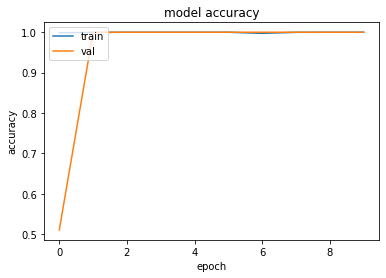

In [18]:
# history of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

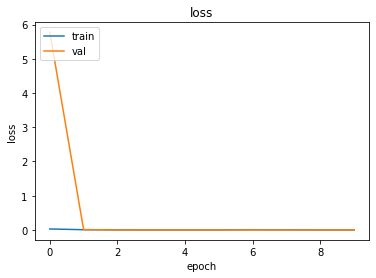

In [19]:
# history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
len(fcn_dfbw.get_weights())

20

In [21]:
print("duration : {} seconds".format(duration))

duration : 160.8133900165558 seconds


In [22]:
# save model
fcn_dfbw.save('fcn_dfbw.hdf5')

### fcn_dfma

In [23]:
# get_input
X_train, X_test, y_train, y_test = get_input(df_ma)

# model
input_shape = X_train.shape[1:]
nb_classes = 1

batch_size = 16
nb_epochs = 10 #5000

fcn_dfma = build_model(input_shape, nb_classes)

start_time = time.time()
history = fcn_dfma.fit(X_train, y_train, validation_split=0.30, 
                       epochs=nb_epochs, batch_size=batch_size, verbose=0)
duration = time.time() - start_time

fcn_dfma.summary()

Train set: (8000, 3000, 4)
Test set : (2000, 3000, 4)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3000, 4)]         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3000, 128)         4224      
_________________________________________________________________
batch_normalization_6 (Batch (None, 3000, 128)         512       
_________________________________________________________________
activation_6 (Activation)    (None, 3000, 128)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3000, 256)         164096    
_________________________________________________________________
batch_normalization_7 (Batch (None, 3000, 256)         1024      
_________________________________________________________________
activ

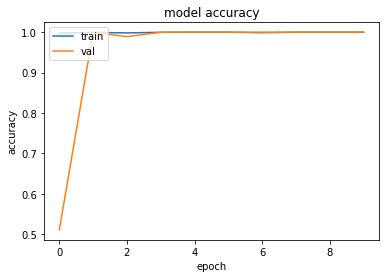

In [24]:
# history of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

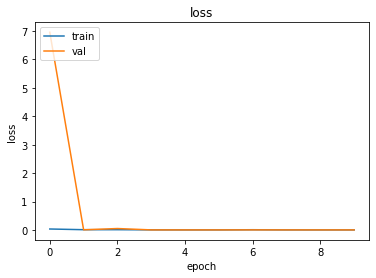

In [25]:
# history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
print("duration : {} seconds".format(duration))

duration : 160.59802222251892 seconds


In [27]:
# save model
fcn_dfma.save('fcn_dfma.hdf5')

### fcn_dfgn

In [28]:
# get_input
X_train, X_test, y_train, y_test = get_input(df_gn)

# model
input_shape = X_train.shape[1:]
nb_classes = 1

batch_size = 16
nb_epochs = 10 #5000

fcn_dfgn = build_model(input_shape, nb_classes)

start_time = time.time()
history = fcn_dfgn.fit(X_train, y_train, validation_split=0.30, 
                       epochs=nb_epochs, batch_size=batch_size, verbose=0)
duration = time.time() - start_time

fcn_dfgn.summary()

Train set: (8000, 3000, 4)
Test set : (2000, 3000, 4)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3000, 4)]         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3000, 128)         4224      
_________________________________________________________________
batch_normalization_9 (Batch (None, 3000, 128)         512       
_________________________________________________________________
activation_9 (Activation)    (None, 3000, 128)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 3000, 256)         164096    
_________________________________________________________________
batch_normalization_10 (Batc (None, 3000, 256)         1024      
_________________________________________________________________
activ

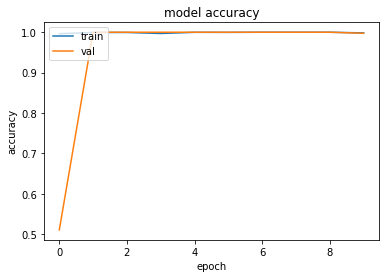

In [29]:
# history of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

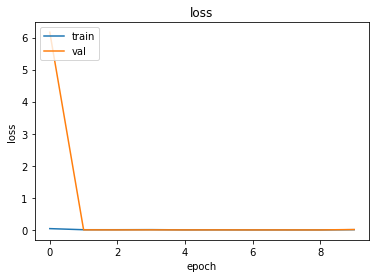

In [30]:
# history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
print("duration : {} seconds".format(duration))

duration : 160.70218420028687 seconds


In [32]:
# save model
fcn_dfgn.save('fcn_dfgn.hdf5')